In [1]:
import yfinance as yf
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from ta.momentum import RSIIndicator
from collections import deque
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import datetime
from matplotlib import pyplot as plt
import time

## Gathering the data


### Downloading the initial data


In [2]:
# The main ticker to predict
TICKER_TO_PREDICT = "SPY"
# Supplementary tickers to help prediction
INDICATOR_TICKERS = ["QQQ", "^TNX", "^VIX", "CL=F"]

# The last day which the training data should include
TRAIN_DATA_END_DATE = datetime.datetime(2023, 5, 2)

In [3]:
df = yf.download(
    TICKER_TO_PREDICT,
    end=(TRAIN_DATA_END_DATE + datetime.timedelta(1)).strftime("%Y-%m-%d"),
    progress=False,
)
df.drop(columns=["Adj Close"], inplace=True)
df.rename(
    columns={col: f"{TICKER_TO_PREDICT}_{col}" for col in df.columns}, inplace=True
)
CLOSE_NAME = f"{TICKER_TO_PREDICT}_Close"

df

,SPY_Open,SPY_High,SPY_Low,SPY_Close,SPY_Volume
Date,,,,,
1993-01-29,43.968750,43.968750,43.750000,43.937500,1003200
1993-02-01,43.968750,44.250000,43.968750,44.250000,480500
1993-02-02,44.218750,44.375000,44.125000,44.343750,201300
1993-02-03,44.406250,44.843750,44.375000,44.812500,529400
1993-02-04,44.968750,45.093750,44.468750,45.000000,531500
...,...,...,...,...,...
2023-04-26,406.720001,407.839996,403.779999,404.359985,80447000
2023-04-27,407.000000,412.690002,406.739990,412.410004,92968400
2023-04-28,411.489990,415.940002,411.429993,415.929993,89335600


### Adding technical indicators


In [4]:
df[f"{CLOSE_NAME}_RSI"] = RSIIndicator(df[CLOSE_NAME], window=14).rsi()
df.dropna(inplace=True)

df

,SPY_Open,SPY_High,SPY_Low,SPY_Close,SPY_Volume,SPY_Close_RSI
Date,,,,,,
1993-02-18,43.937500,43.937500,42.812500,43.406250,378100,31.343145
1993-02-19,43.406250,43.562500,43.343750,43.562500,34900,36.183605
1993-02-22,43.687500,43.781250,43.562500,43.718750,513600,40.686975
1993-02-23,43.843750,43.875000,43.468750,43.687500,373700,40.077825
1993-02-24,43.718750,44.250000,43.718750,44.250000,26300,53.556588
...,...,...,...,...,...,...
2023-04-26,406.720001,407.839996,403.779999,404.359985,80447000,45.737663
2023-04-27,407.000000,412.690002,406.739990,412.410004,92968400,57.205268
2023-04-28,411.489990,415.940002,411.429993,415.929993,89335600,61.078657


### Joining the indicator ticker data


In [5]:
for ticker in INDICATOR_TICKERS:
    ticker_data = yf.download(ticker, progress=False)
    print(ticker, ticker_data.columns)

QQQ Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
^TNX Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
^VIX Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
CL=F Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [6]:
RELEVANT_COLS = ["Close"]

for ticker in INDICATOR_TICKERS:
    ticker_data = yf.download(ticker, progress=False)
    relevant_data = ticker_data[RELEVANT_COLS]
    relevant_data = relevant_data.rename(
        columns={col: f"{ticker}_{col}" for col in RELEVANT_COLS}
    )
    # Only join if the columns aren't already present
    if len(set(df.columns).intersection(set(relevant_data.columns))) == 0:
        df = df.join(relevant_data)

df.dropna(inplace=True)
print(df.columns)

df

Index(['SPY_Open', 'SPY_High', 'SPY_Low', 'SPY_Close', 'SPY_Volume',
       'SPY_Close_RSI', 'QQQ_Close', '^TNX_Close', '^VIX_Close', 'CL=F_Close'],
      dtype='object')


,SPY_Open,SPY_High,SPY_Low,SPY_Close,SPY_Volume,SPY_Close_RSI,QQQ_Close,^TNX_Close,^VIX_Close,CL=F_Close
Date,,,,,,,,,,
2000-08-23,149.812500,151.281250,149.281250,150.843750,5483200,60.811526,97.062500,5.725,17.379999,32.049999
2000-08-24,151.156250,151.500000,150.500000,151.312500,4529000,62.225237,98.562500,5.716,17.040001,31.629999
2000-08-25,151.156250,151.625000,150.937500,151.250000,2822200,61.904574,98.031250,5.721,16.530001,32.049999
2000-08-28,151.250000,152.906250,151.250000,151.765625,5518700,63.572401,98.500000,5.766,16.540001,32.869999
2000-08-29,151.437500,151.875000,150.906250,151.796875,3561900,63.676195,99.000000,5.808,16.889999,32.720001
...,...,...,...,...,...,...,...,...,...,...
2023-04-26,406.720001,407.839996,403.779999,404.359985,80447000,45.737663,311.869995,3.432,18.840000,74.300003
2023-04-27,407.000000,412.690002,406.739990,412.410004,92968400,57.205268,320.350006,3.528,17.030001,74.760002
2023-04-28,411.489990,415.940002,411.429993,415.929993,89335600,61.078657,322.559998,3.452,15.780000,76.779999


## Processing the data


### Offsetting the data and adding target values


In [7]:
# Length of sequences to feed the RNN
SEQUENCE_LEN = 60
# Number of periods (days if data is daily) in the future to predict
PREDICTION_PERIOD_OFFSET = 20

In [8]:
def classify(current, future):
    return int(float(future) > float(current))

In [9]:
df[f"{CLOSE_NAME}_Future"] = df[CLOSE_NAME].shift(-1 * PREDICTION_PERIOD_OFFSET)
df.dropna(inplace=True)
df["Target"] = list(map(classify, df[CLOSE_NAME], df[f"{CLOSE_NAME}_Future"]))

df[[CLOSE_NAME, f"{CLOSE_NAME}_Future", "Target"]]

,SPY_Close,SPY_Close_Future,Target
Date,,,
2000-08-23,150.843750,142.687500,0
2000-08-24,151.312500,145.281250,0
2000-08-25,151.250000,144.250000,0
2000-08-28,151.765625,142.406250,0
2000-08-29,151.796875,143.156250,0
...,...,...,...
2023-03-28,395.600006,404.359985,1
2023-03-29,401.350006,412.410004,1
2023-03-30,403.700012,415.929993,1


### Splitting the data into training, validation and test sets


In [10]:
# The percentage of data to keep for the validation and test set
NON_TRAIN_PCT = 0.2
# The percentage of non-training data to use for the validation set (the rest is used for the test set)
VALIDATION_TRAIN_RATIO = 0.75

In [11]:
df

,SPY_Open,SPY_High,SPY_Low,SPY_Close,SPY_Volume,SPY_Close_RSI,QQQ_Close,^TNX_Close,^VIX_Close,CL=F_Close,SPY_Close_Future,Target
Date,,,,,,,,,,,,
2000-08-23,149.812500,151.281250,149.281250,150.843750,5483200,60.811526,97.062500,5.725,17.379999,32.049999,142.687500,0
2000-08-24,151.156250,151.500000,150.500000,151.312500,4529000,62.225237,98.562500,5.716,17.040001,31.629999,145.281250,0
2000-08-25,151.156250,151.625000,150.937500,151.250000,2822200,61.904574,98.031250,5.721,16.530001,32.049999,144.250000,0
2000-08-28,151.250000,152.906250,151.250000,151.765625,5518700,63.572401,98.500000,5.766,16.540001,32.869999,142.406250,0
2000-08-29,151.437500,151.875000,150.906250,151.796875,3561900,63.676195,99.000000,5.808,16.889999,32.720001,143.156250,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-28,395.769989,396.489990,393.690002,395.600006,62871700,49.308792,307.119995,3.564,19.969999,73.199997,404.359985,1
2023-03-29,399.929993,401.600006,398.679993,401.350006,77497900,55.088303,312.720001,3.566,19.120001,72.970001,412.410004,1
2023-03-30,404.089996,404.350006,401.760010,403.700012,69840000,57.234351,315.679993,3.551,19.020000,74.370003,415.929993,1


In [12]:
TOTAL_DF_LEN = len(df.index)
train_split_index = -1 * int(NON_TRAIN_PCT * TOTAL_DF_LEN)
train_df, non_train_df = df[:train_split_index], df[train_split_index:]

non_train_split_index = -1 * int((1 - VALIDATION_TRAIN_RATIO) * len(non_train_df.index))
validation_df, test_df = (
    non_train_df[:non_train_split_index],
    non_train_df[non_train_split_index:],
)

print("NON-BALANCED DATA:")
print(
    f"TRAIN: {len(train_df)} ({len(train_df) / TOTAL_DF_LEN * 100}%), NON-TRAIN: {len(non_train_df)} ({len(non_train_df) / TOTAL_DF_LEN * 100}%)"
)
print(
    f"VALIDATION: {len(validation_df)} ({len(validation_df) / TOTAL_DF_LEN * 100}%), TEST: {len(test_df)} ({len(test_df) / TOTAL_DF_LEN * 100}%)"
)

NON-BALANCED DATA:
TRAIN: 4535 (80.01058574453069%), NON-TRAIN: 1133 (19.989414255469303%)
VALIDATION: 850 (14.996471418489769%), TEST: 283 (4.992942836979535%)


### Preprocess the training and non-training data


In [13]:
def preprocess_df(df, balance=True):
    TICKER = df.columns[0].split("_")[0]
    CLOSE_NAME = TICKER + "_Close"
    df = df.drop(columns=[f"{CLOSE_NAME}_Future"])

    # Scale the data
    for col in df.columns:
        if col != "Target":
            df[col] = df[col].pct_change()
            df.replace([np.inf, -np.inf], np.nan, inplace=True)
            df.dropna(inplace=True)
            df[col] = preprocessing.scale(df[col].values)

    df.dropna(inplace=True)

    # Create the sequential data
    sequential_data = []
    data_queue = deque(maxlen=SEQUENCE_LEN)

    for datapoint in df.values:
        # The last column in the df will be Target. Don't include this in the list of independent features
        data_queue.append(datapoint[:-1])
        if len(data_queue) == SEQUENCE_LEN:
            sequential_data.append([np.array(data_queue), datapoint[-1]])

    random.shuffle(sequential_data)

    if balance:
        # Balance the dataset
        buys = []
        sells = []

        for seq, target in sequential_data:
            if target:
                buys.append([seq, target])
            else:
                sells.append([seq, target])

        minimum = min(len(buys), len(sells))

        random.shuffle(buys)
        random.shuffle(sells)

        buys = buys[:minimum]
        sells = sells[:minimum]

        sequential_data = buys + sells
        random.shuffle(sequential_data)

    X = []
    y = []

    for seq, target in sequential_data:
        X.append(seq)
        y.append(target)

    return np.array(X), np.array(y)

In [14]:
X_train, y_train = preprocess_df(train_df)
X_validation, y_validation = preprocess_df(validation_df)
X_test, y_test = preprocess_df(test_df)

print(
    f"""
BALANCED DATA:
Train: {len(X_train)}
Validation: {len(X_validation)}
Test: {len(X_test)}
"""
)


BALANCED DATA:
Train: 3374
Validation: 428
Test: 198



## Training the model


In [15]:
EPOCHS = 10
BATCH_SIZE = 32

In [20]:
model = Sequential(
    [
        LSTM(20),
        Dropout(0.3),
        BatchNormalization(),
        Dense(16, activation="gelu"),
        Dropout(0.3),
        Dense(16, activation="gelu"),
        Dropout(0.3),
        Dense(2, activation="softmax"),
    ]
)
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=np.ceil(len(X_train) / BATCH_SIZE),
    decay_rate=0.7,
)
opt = Adam(learning_rate=lr_schedule)
model.compile(
    optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_validation, y_validation),
)

Epoch 1/10
106/106 [==============================] - 5s 23ms/step - loss: 0.7139 - accuracy: 0.5104 - val_loss: 0.6942 - val_accuracy: 0.4720
Epoch 2/10
106/106 [==============================] - 2s 19ms/step - loss: 0.7052 - accuracy: 0.5122 - val_loss: 0.6949 - val_accuracy: 0.4883
Epoch 3/10
106/106 [==============================] - 2s 19ms/step - loss: 0.7011 - accuracy: 0.5006 - val_loss: 0.6953 - val_accuracy: 0.4883
Epoch 4/10
106/106 [==============================] - 2s 20ms/step - loss: 0.6915 - accuracy: 0.5261 - val_loss: 0.6950 - val_accuracy: 0.5023
Epoch 5/10
106/106 [==============================] - 2s 19ms/step - loss: 0.6929 - accuracy: 0.5314 - val_loss: 0.6940 - val_accuracy: 0.5047
Epoch 6/10
106/106 [==============================] - 2s 19ms/step - loss: 0.6959 - accuracy: 0.5110 - val_loss: 0.6937 - val_accuracy: 0.5047
Epoch 7/10
106/106 [==============================] - 2s 19ms/step - loss: 0.6933 - accuracy: 0.5282 - val_loss: 0.6934 - val_accuracy: 0.5070

In [28]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 20)                2480      
                                                                 
 dropout_12 (Dropout)        (None, 20)                0         
                                                                 
 batch_normalization_4 (Batc  (None, 20)               80        
 hNormalization)                                                 
                                                                 
 dense_12 (Dense)            (None, 16)                336       
                                                                 
 dropout_13 (Dropout)        (None, 16)                0         
                                                                 
 dense_13 (Dense)            (None, 16)                272       
                                                      

### Saving the model


In [29]:
model.save("./models/SPY")

INFO:tensorflow:Assets written to: ./models/SPY\assets


INFO:tensorflow:Assets written to: ./models/SPY\assets


### Loading in the model


In [15]:
model = tf.keras.models.load_model("./models/SPY")

## Evaluating the model


### Confusion Matrix


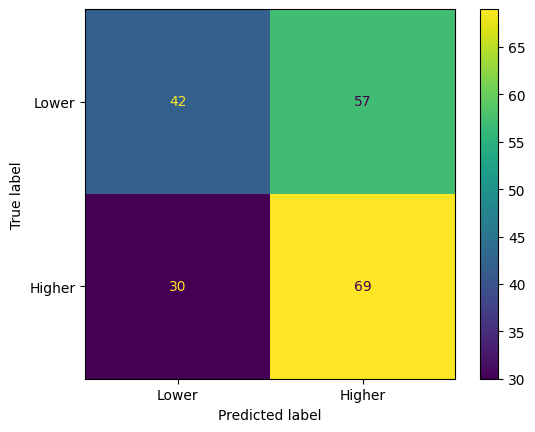

In [16]:
logits = model(X_test, training=False)
predictions = tf.math.argmax(logits, axis=1, output_type=tf.int64)
cf_matrix = confusion_matrix(y_test, predictions)
cm_display = ConfusionMatrixDisplay(cf_matrix, display_labels=["Lower", "Higher"])
cm_display.plot()
plt.show()

### Precision and Recall

In [17]:
logits = model(X_test, training=False)
predictions = tf.math.argmax(logits, axis=1, output_type=tf.int64)
print(classification_report(y_test, predictions, target_names=["Lower", "Higher"]))

              precision    recall  f1-score   support

       Lower       0.58      0.42      0.49        99
      Higher       0.55      0.70      0.61        99

    accuracy                           0.56       198
   macro avg       0.57      0.56      0.55       198
weighted avg       0.57      0.56      0.55       198



### Testing on the test dataset


In [18]:
logits = model(X_test, training=False)
predictions = tf.math.argmax(logits, axis=1, output_type=tf.int64)
test_accuracy = tf.keras.metrics.Accuracy()
test_accuracy(predictions, y_test)

<tf.Tensor: shape=(), dtype=float32, numpy=0.56060606>

### Testing on the entire dataset


In [19]:
X, y = preprocess_df(df)

logits = model(X, training=False)
predictions = tf.math.argmax(logits, axis=1, output_type=tf.int64)
test_accuracy = tf.keras.metrics.Accuracy()
test_accuracy(predictions, y)

<tf.Tensor: shape=(), dtype=float32, numpy=0.5433637>

### Testing on various stock tickers (within the S&P500)


In [20]:
def test_ticker(TICKER):
    df = yf.download(TICKER, progress=False)
    df.drop(columns=["Adj Close"], inplace=True)
    df.rename(columns={col: f"{TICKER}_{col}" for col in df.columns}, inplace=True)

    df[f"{TICKER}_Close_RSI"] = RSIIndicator(df[f"{TICKER}_Close"], window=14).rsi()
    df.dropna(inplace=True)

    for ticker in INDICATOR_TICKERS:
        ticker_data = yf.download(ticker, progress=False)
        relevant_data = ticker_data[RELEVANT_COLS]
        relevant_data = relevant_data.rename(
            columns={col: f"{ticker}_{col}" for col in RELEVANT_COLS}
        )
        # Only join if the columns aren't already present
        if len(set(df.columns).intersection(set(relevant_data.columns))) == 0:
            df = df.join(relevant_data)

    df.dropna(inplace=True)

    df[f"{TICKER}_Close_Future"] = df[f"{TICKER}_Close"].shift(
        -1 * PREDICTION_PERIOD_OFFSET
    )
    df.dropna(inplace=True)
    df["Target"] = list(
        map(classify, df[f"{TICKER}_Close"], df[f"{TICKER}_Close_Future"])
    )

    X, y = preprocess_df(df, balance=False)

    print("Starting inference")
    start = time.time()
    logits = model(X, training=False)
    print("End of inference")
    print(f"Inference took: {time.time() - start}s")
    predictions = tf.math.argmax(logits, axis=1, output_type=tf.int64)
    test_accuracy = tf.keras.metrics.Accuracy()

    return test_accuracy(predictions, y)

In [21]:
test_ticker("AAPL")

Starting inference
End of inference
Inference took: 0.38651442527770996s


<tf.Tensor: shape=(), dtype=float32, numpy=0.5161063>

In [22]:
test_ticker("MSFT")

Starting inference
End of inference
Inference took: 0.3657703399658203s


<tf.Tensor: shape=(), dtype=float32, numpy=0.5250836>

In [23]:
test_ticker("V")

Starting inference
End of inference
Inference took: 0.29278111457824707s


<tf.Tensor: shape=(), dtype=float32, numpy=0.5359408>

In [24]:
test_ticker("HD")

Starting inference
End of inference
Inference took: 0.3668246269226074s


<tf.Tensor: shape=(), dtype=float32, numpy=0.5403978>

In [25]:
test_ticker("KO")

Starting inference
End of inference
Inference took: 0.3689110279083252s


<tf.Tensor: shape=(), dtype=float32, numpy=0.5222672>

In [26]:
test_ticker("JPM")

Starting inference
End of inference
Inference took: 0.3810429573059082s


<tf.Tensor: shape=(), dtype=float32, numpy=0.5259637>

### Testing on various stock tickers (not in the S&P500)


In [27]:
test_ticker("MC.PA")

Starting inference
End of inference
Inference took: 0.37306928634643555s


<tf.Tensor: shape=(), dtype=float32, numpy=0.522877>

In [28]:
test_ticker("TTE")

Starting inference
End of inference
Inference took: 0.3758518695831299s


<tf.Tensor: shape=(), dtype=float32, numpy=0.5433903>

In [29]:
test_ticker("LIN")

Starting inference
End of inference
Inference took: 0.3683333396911621s


<tf.Tensor: shape=(), dtype=float32, numpy=0.5294843>